###Mount Google Drive on this notebook

In [1]:
# optional - run this block if using colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
os.chdir("/content/gdrive/My Drive/")

In [3]:
!ls

 AppReviewFortuneCity_new.mp4   pytorch_vggish.pth    valid_dataset_b.csv
 balanced_data.csv	        temp_882rows.csv      valid_dataset.csv
'Colab Notebooks'	        test_dataset_b.csv    vggish_dataset.csv
 combined_data_clean2.csv       test_dataset.csv      vggish_dataset_new.csv
 coswara		        train_dataset_b.csv   下載.jpg
 distribution		        train_dataset.csv


In [4]:
import pandas as pd
import numpy as np
import os
import tqdm
from tqdm import tqdm_notebook
from pathlib import Path
import math
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

###VGGish

In [6]:
import torch.nn as nn


class VGGish(nn.Module):
    """
    PyTorch implementation of the VGGish model.

    Adapted from: https://github.com/harritaylor/torch-vggish
    The following modifications were made: (i) correction for the missing ReLU layers, (ii) correction for the
    improperly formatted data when transitioning from NHWC --> NCHW in the fully-connected layers, and (iii)
    correction for flattening in the fully-connected layers.
    """

    def __init__(self):
        super(VGGish, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 24, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 128),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.features(x).permute(0, 2, 3, 1).contiguous()
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def main():
    pass


if __name__ == '__main__':
    main()


###VGGish pytorch helper functions

In [7]:
## mel features ##

# Copyright 2017 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Defines routines to compute mel spectrogram features from audio waveform."""

import numpy as np


def frame(data, window_length, hop_length):
  """Convert array into a sequence of successive possibly overlapping frames.

  An n-dimensional array of shape (num_samples, ...) is converted into an
  (n+1)-D array of shape (num_frames, window_length, ...), where each frame
  starts hop_length points after the preceding one.

  This is accomplished using stride_tricks, so the original data is not
  copied.  However, there is no zero-padding, so any incomplete frames at the
  end are not included.

  Args:
    data: np.array of dimension N >= 1.
    window_length: Number of samples in each frame.
    hop_length: Advance (in samples) between each window.

  Returns:
    (N+1)-D np.array with as many rows as there are complete frames that can be
    extracted.
  """
  num_samples = data.shape[0]
  num_frames = 1 + int(np.floor((num_samples - window_length) / hop_length))
  shape = (num_frames, window_length) + data.shape[1:]
  strides = (data.strides[0] * hop_length,) + data.strides
  return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)


def periodic_hann(window_length):
  """Calculate a "periodic" Hann window.

  The classic Hann window is defined as a raised cosine that starts and
  ends on zero, and where every value appears twice, except the middle
  point for an odd-length window.  Matlab calls this a "symmetric" window
  and np.hanning() returns it.  However, for Fourier analysis, this
  actually represents just over one cycle of a period N-1 cosine, and
  thus is not compactly expressed on a length-N Fourier basis.  Instead,
  it's better to use a raised cosine that ends just before the final
  zero value - i.e. a complete cycle of a period-N cosine.  Matlab
  calls this a "periodic" window. This routine calculates it.

  Args:
    window_length: The number of points in the returned window.

  Returns:
    A 1D np.array containing the periodic hann window.
  """
  return 0.5 - (0.5 * np.cos(2 * np.pi / window_length *
                             np.arange(window_length)))


def stft_magnitude(signal, fft_length,
                   hop_length=None,
                   window_length=None):
  """Calculate the short-time Fourier transform magnitude.

  Args:
    signal: 1D np.array of the input time-domain signal.
    fft_length: Size of the FFT to apply.
    hop_length: Advance (in samples) between each frame passed to FFT.
    window_length: Length of each block of samples to pass to FFT.

  Returns:
    2D np.array where each row contains the magnitudes of the fft_length/2+1
    unique values of the FFT for the corresponding frame of input samples.
  """
  frames = frame(signal, window_length, hop_length)
  # Apply frame window to each frame. We use a periodic Hann (cosine of period
  # window_length) instead of the symmetric Hann of np.hanning (period
  # window_length-1).
  window = periodic_hann(window_length)
  windowed_frames = frames * window
  return np.abs(np.fft.rfft(windowed_frames, int(fft_length)))


# Mel spectrum constants and functions.
_MEL_BREAK_FREQUENCY_HERTZ = 700.0
_MEL_HIGH_FREQUENCY_Q = 1127.0


def hertz_to_mel(frequencies_hertz):
  """Convert frequencies to mel scale using HTK formula.

  Args:
    frequencies_hertz: Scalar or np.array of frequencies in hertz.

  Returns:
    Object of same size as frequencies_hertz containing corresponding values
    on the mel scale.
  """
  return _MEL_HIGH_FREQUENCY_Q * np.log(
      1.0 + (frequencies_hertz / _MEL_BREAK_FREQUENCY_HERTZ))


def spectrogram_to_mel_matrix(num_mel_bins=20,
                              num_spectrogram_bins=129,
                              audio_sample_rate=8000,
                              lower_edge_hertz=125.0,
                              upper_edge_hertz=3800.0):
  """Return a matrix that can post-multiply spectrogram rows to make mel.

  Returns a np.array matrix A that can be used to post-multiply a matrix S of
  spectrogram values (STFT magnitudes) arranged as frames x bins to generate a
  "mel spectrogram" M of frames x num_mel_bins.  M = S A.

  The classic HTK algorithm exploits the complementarity of adjacent mel bands
  to multiply each FFT bin by only one mel weight, then add it, with positive
  and negative signs, to the two adjacent mel bands to which that bin
  contributes.  Here, by expressing this operation as a matrix multiply, we go
  from num_fft multiplies per frame (plus around 2*num_fft adds) to around
  num_fft^2 multiplies and adds.  However, because these are all presumably
  accomplished in a single call to np.dot(), it's not clear which approach is
  faster in Python.  The matrix multiplication has the attraction of being more
  general and flexible, and much easier to read.

  Args:
    num_mel_bins: How many bands in the resulting mel spectrum.  This is
      the number of columns in the output matrix.
    num_spectrogram_bins: How many bins there are in the source spectrogram
      data, which is understood to be fft_size/2 + 1, i.e. the spectrogram
      only contains the nonredundant FFT bins.
    audio_sample_rate: Samples per second of the audio at the input to the
      spectrogram. We need this to figure out the actual frequencies for
      each spectrogram bin, which dictates how they are mapped into mel.
    lower_edge_hertz: Lower bound on the frequencies to be included in the mel
      spectrum.  This corresponds to the lower edge of the lowest triangular
      band.
    upper_edge_hertz: The desired top edge of the highest frequency band.

  Returns:
    An np.array with shape (num_spectrogram_bins, num_mel_bins).

  Raises:
    ValueError: if frequency edges are incorrectly ordered or out of range.
  """
  nyquist_hertz = audio_sample_rate / 2.
  if lower_edge_hertz < 0.0:
    raise ValueError("lower_edge_hertz %.1f must be >= 0" % lower_edge_hertz)
  if lower_edge_hertz >= upper_edge_hertz:
    raise ValueError("lower_edge_hertz %.1f >= upper_edge_hertz %.1f" %
                     (lower_edge_hertz, upper_edge_hertz))
  if upper_edge_hertz > nyquist_hertz:
    raise ValueError("upper_edge_hertz %.1f is greater than Nyquist %.1f" %
                     (upper_edge_hertz, nyquist_hertz))
  spectrogram_bins_hertz = np.linspace(0.0, nyquist_hertz, num_spectrogram_bins)
  spectrogram_bins_mel = hertz_to_mel(spectrogram_bins_hertz)
  # The i'th mel band (starting from i=1) has center frequency
  # band_edges_mel[i], lower edge band_edges_mel[i-1], and higher edge
  # band_edges_mel[i+1].  Thus, we need num_mel_bins + 2 values in
  # the band_edges_mel arrays.
  band_edges_mel = np.linspace(hertz_to_mel(lower_edge_hertz),
                               hertz_to_mel(upper_edge_hertz), num_mel_bins + 2)
  # Matrix to post-multiply feature arrays whose rows are num_spectrogram_bins
  # of spectrogram values.
  mel_weights_matrix = np.empty((num_spectrogram_bins, num_mel_bins))
  for i in range(num_mel_bins):
    lower_edge_mel, center_mel, upper_edge_mel = band_edges_mel[i:i + 3]
    # Calculate lower and upper slopes for every spectrogram bin.
    # Line segments are linear in the *mel* domain, not hertz.
    lower_slope = ((spectrogram_bins_mel - lower_edge_mel) /
                   (center_mel - lower_edge_mel))
    upper_slope = ((upper_edge_mel - spectrogram_bins_mel) /
                   (upper_edge_mel - center_mel))
    # .. then intersect them with each other and zero.
    mel_weights_matrix[:, i] = np.maximum(0.0, np.minimum(lower_slope,
                                                          upper_slope))
  # HTK excludes the spectrogram DC bin; make sure it always gets a zero
  # coefficient.
  mel_weights_matrix[0, :] = 0.0
  return mel_weights_matrix


def log_mel_spectrogram(data,
                        audio_sample_rate=8000,
                        log_offset=0.0,
                        window_length_secs=0.025,
                        hop_length_secs=0.010,
                        **kwargs):
  """Convert waveform to a log magnitude mel-frequency spectrogram.

  Args:
    data: 1D np.array of waveform data.
    audio_sample_rate: The sampling rate of data.
    log_offset: Add this to values when taking log to avoid -Infs.
    window_length_secs: Duration of each window to analyze.
    hop_length_secs: Advance between successive analysis windows.
    **kwargs: Additional arguments to pass to spectrogram_to_mel_matrix.

  Returns:
    2D np.array of (num_frames, num_mel_bins) consisting of log mel filterbank
    magnitudes for successive frames.
  """
  window_length_samples = int(round(audio_sample_rate * window_length_secs))
  hop_length_samples = int(round(audio_sample_rate * hop_length_secs))
  fft_length = 2 ** int(np.ceil(np.log(window_length_samples) / np.log(2.0)))
  spectrogram = stft_magnitude(
      data,
      fft_length=fft_length,
      hop_length=hop_length_samples,
      window_length=window_length_samples)
  mel_spectrogram = np.dot(spectrogram, spectrogram_to_mel_matrix(
      num_spectrogram_bins=spectrogram.shape[1],
      audio_sample_rate=audio_sample_rate, **kwargs))
  return np.log(mel_spectrogram + log_offset)

## vgg param ##
# Copyright 2017 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Global parameters for the VGGish model.

See vggish_slim.py for more information.
"""

# Architectural constants.
NUM_FRAMES = 96  # Frames in input mel-spectrogram patch.
NUM_BANDS = 64  # Frequency bands in input mel-spectrogram patch.
EMBEDDING_SIZE = 128  # Size of embedding layer.

# Hyperparameters used in feature and example generation.
SAMPLE_RATE = 16000
STFT_WINDOW_LENGTH_SECONDS = 0.025
STFT_HOP_LENGTH_SECONDS = 0.010
NUM_MEL_BINS = NUM_BANDS
MEL_MIN_HZ = 125
MEL_MAX_HZ = 7500
LOG_OFFSET = 0.01  # Offset used for stabilized log of input mel-spectrogram.
EXAMPLE_WINDOW_SECONDS = 0.96  # Each example contains 96 10ms frames
EXAMPLE_HOP_SECONDS = 0.96     # with zero overlap.

# Parameters used for embedding postprocessing.
PCA_EIGEN_VECTORS_NAME = 'pca_eigen_vectors'
PCA_MEANS_NAME = 'pca_means'
QUANTIZE_MIN_VAL = -2.0
QUANTIZE_MAX_VAL = +2.0

# Hyperparameters used in training.
INIT_STDDEV = 0.01  # Standard deviation used to initialize weights.
LEARNING_RATE = 1e-4  # Learning rate for the Adam optimizer.
ADAM_EPSILON = 1e-8  # Epsilon for the Adam optimizer.

# Names of ops, tensors, and features.
INPUT_OP_NAME = 'vggish/input_features'
INPUT_TENSOR_NAME = INPUT_OP_NAME + ':0'
OUTPUT_OP_NAME = 'vggish/embedding'
OUTPUT_TENSOR_NAME = OUTPUT_OP_NAME + ':0'
AUDIO_EMBEDDING_FEATURE_NAME = 'audio_embedding'



## input ##
# Copyright 2017 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Compute input examples for VGGish from audio waveform."""

import numpy as np
import resampy


import soundfile as sf


def waveform_to_examples(data, sample_rate):
  """Converts audio waveform into an array of examples for VGGish.

  Args:
    data: np.array of either one dimension (mono) or two dimensions
      (multi-channel, with the outer dimension representing channels).
      Each sample is generally expected to lie in the range [-1.0, +1.0],
      although this is not required.
    sample_rate: Sample rate of data.

  Returns:
    3-D np.array of shape [num_examples, num_frames, num_bands] which represents
    a sequence of examples, each of which contains a patch of log mel
    spectrogram, covering num_frames frames of audio and num_bands mel frequency
    bands, where the frame length is vggish_params.STFT_HOP_LENGTH_SECONDS.
  """
  # Convert to mono.
  if len(data.shape) > 1:
    data = np.mean(data, axis=1)
  # Resample to the rate assumed by VGGish.
  if sample_rate != SAMPLE_RATE:
    data = resampy.resample(data, sample_rate, SAMPLE_RATE)

  # Compute log mel spectrogram features.
  log_mel = log_mel_spectrogram(
      data,
      audio_sample_rate=SAMPLE_RATE,
      log_offset=LOG_OFFSET,
      window_length_secs=STFT_WINDOW_LENGTH_SECONDS,
      hop_length_secs=STFT_HOP_LENGTH_SECONDS,
      num_mel_bins=NUM_MEL_BINS,
      lower_edge_hertz=MEL_MIN_HZ,
      upper_edge_hertz=MEL_MAX_HZ)

  # Frame features into examples.
  features_sample_rate = 1.0 / STFT_HOP_LENGTH_SECONDS
  example_window_length = int(round(
      EXAMPLE_WINDOW_SECONDS * features_sample_rate))
  example_hop_length = int(round(
      EXAMPLE_HOP_SECONDS * features_sample_rate))
  log_mel_examples = frame(
      log_mel,
      window_length=example_window_length,
      hop_length=example_hop_length)
  return log_mel_examples


def wavfile_to_examples(wav_file):
  """Convenience wrapper around waveform_to_examples() for a common WAV format.

  Args:
    wav_file: String path to a file, or a file-like object. The file
    is assumed to contain WAV audio data with signed 16-bit PCM samples.

  Returns:
    See waveform_to_examples.
  """
  wav_data, sr = sf.read(wav_file, dtype='int16')
  assert wav_data.dtype == np.int16, 'Bad sample type: %r' % wav_data.dtype
  samples = wav_data / 32768.0  # Convert to [-1.0, +1.0]
  return waveform_to_examples(samples, sr)


## post process ##
# Copyright 2017 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Post-process embeddings from VGGish."""

import numpy as np



class Postprocessor(object):
  """Post-processes VGGish embeddings.

  The initial release of AudioSet included 128-D VGGish embeddings for each
  segment of AudioSet. These released embeddings were produced by applying
  a PCA transformation (technically, a whitening transform is included as well)
  and 8-bit quantization to the raw embedding output from VGGish, in order to
  stay compatible with the YouTube-8M project which provides visual embeddings
  in the same format for a large set of YouTube videos. This class implements
  the same PCA (with whitening) and quantization transformations.
  """

  def __init__(self, pca_params_npz_path):
    """Constructs a postprocessor.

    Args:
      pca_params_npz_path: Path to a NumPy-format .npz file that
        contains the PCA parameters used in postprocessing.
    """
    params = np.load(pca_params_npz_path)
    self._pca_matrix = params[PCA_EIGEN_VECTORS_NAME]
    # Load means into a column vector for easier broadcasting later.
    self._pca_means = params[PCA_MEANS_NAME].reshape(-1, 1)
    assert self._pca_matrix.shape == (
        EMBEDDING_SIZE, EMBEDDING_SIZE), (
            'Bad PCA matrix shape: %r' % (self._pca_matrix.shape,))
    assert self._pca_means.shape == (EMBEDDING_SIZE, 1), (
        'Bad PCA means shape: %r' % (self._pca_means.shape,))

  def postprocess(self, embeddings_batch):
    """Applies postprocessing to a batch of embeddings.

    Args:
      embeddings_batch: An nparray of shape [batch_size, embedding_size]
        containing output from the embedding layer of VGGish.

    Returns:
      An nparray of the same shape as the input but of type uint8,
      containing the PCA-transformed and quantized version of the input.
    """
    assert len(embeddings_batch.shape) == 2, (
        'Expected 2-d batch, got %r' % (embeddings_batch.shape,))
    assert embeddings_batch.shape[1] == EMBEDDING_SIZE, (
        'Bad batch shape: %r' % (embeddings_batch.shape,))

    # Apply PCA.
    # - Embeddings come in as [batch_size, embedding_size].
    # - Transpose to [embedding_size, batch_size].
    # - Subtract pca_means column vector from each column.
    # - Premultiply by PCA matrix of shape [output_dims, input_dims]
    #   where both are are equal to embedding_size in our case.
    # - Transpose result back to [batch_size, embedding_size].
    pca_applied = np.dot(self._pca_matrix,
                         (embeddings_batch.T - self._pca_means)).T

    # Quantize by:
    # - clipping to [min, max] range
    clipped_embeddings = np.clip(
        pca_applied, QUANTIZE_MIN_VAL,
        QUANTIZE_MAX_VAL)
    # - convert to 8-bit in range [0.0, 255.0]
    quantized_embeddings = (
            (clipped_embeddings - QUANTIZE_MIN_VAL) *
            (255.0 /
             (QUANTIZE_MAX_VAL - QUANTIZE_MIN_VAL)))
    # - cast 8-bit float to uint8
    quantized_embeddings = quantized_embeddings.astype(np.uint8)

    return quantized_embeddings



###Load data, output and save vggish embeddings (run this block once only to produce the csv)

In [ ]:
# data is located under the folder distribution
data_path = 'distribution/'

# sample rate is 16000
s_rate = 16000

# Initialize the PyTorch model.
pytorch_model = VGGish()
pytorch_model.load_state_dict(torch.load('pytorch_vggish.pth'))
pytorch_model = pytorch_model.to(device)

#def load_data(data_path, s_rate = 16000):  # 如果出现小于-20情况跳过当前音频文件
combined_data_df = pd.read_csv('combined_data_clean2.csv')
all_data = pd.DataFrame(columns=range(1,129))

for file_path in tqdm.tqdm(list(Path(data_path).iterdir()), desc='Date'):
    print(str(file_path))
    file_path = file_path.absolute()
    path1 = Path.joinpath(file_path, file_path.stem)
    #print('path1')
    #print(path1)
    for path2 in Path(path1).iterdir():
        skip = False
        total_data = pd.DataFrame(columns=range(1,129))
        id = path2.stem
        #print('processing id:')
        #print(id)
        for path3 in Path(path2).glob('*.dat'):
            df = pd.read_csv(path3, header=None)

            # break if any value < -20
            for item in df.min():
                if item < -20.0:
                    #print('Drop id: {}'.format(id))
                    skip = True
                    break
            if skip:
                break


            # get VGGish embeddings output
            df_values = df.values.flatten()
            if len(df_values) < s_rate:
              df_values.resize(s_rate)

            df_inputs = waveform_to_examples(df_values, s_rate)
            df_inputs = torch.from_numpy(df_inputs).unsqueeze(dim=1)
            df_inputs = df_inputs.float().to(device)

            df_outputs = pytorch_model(df_inputs)
            df_outputs = df_outputs.detach().cpu().numpy()
            df_outputs = df_outputs.mean(axis=0)

            sound_file =  str(path3)[str(path3).rfind('/')+1:len(str(path3))-4]
            total_data.loc[sound_file] = df_outputs

        if id in list(combined_data_df['id']):
          label = combined_data_df.loc[combined_data_df['id'] == id, 'covid_status'].values[0]
        else:
          skip = True
          break
        if label == 'healthy':
          total_data['label'] = 1
        else:
          total_data['label'] = 0

        if skip != True:
          all_data = all_data.append(total_data)


all_data.to_csv('vggish_dataset_new.csv'.format(id), index=False)


Date:   0%|          | 0/40 [00:00<?, ?it/s]

distribution/20200504


Date:   0%|          | 0/40 [00:05<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
all_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,label
lcmfMfcc.breathing-deep,0.0,0.257079,0.251250,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.000000,0.0,0.793582,0.0,0.057088,0.081109,0.400316,0.0,0.000000,0.000000,0.045205,0.000000,0.0,0.000000,0.421031,0.000000,0.267444,0.315332,0.165995,0.076293,0.000000,0.310387,0.0,0.009565,0.427322,0.790336,0.0,0.0,0.588196,...,0.136521,0.0,0.202354,0.148538,1.118179,0.0,0.452398,0.040099,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.005773,0.0,0.000000,0.062799,0.000000,0.012860,0.012382,0.048849,0.0,0.0,0.0,0.296784,0.0,0.045190,0.224362,0.083323,0.0,0.012778,0.0,0.0,0.0,0.0,1.0
lcmfMfcc.counting-fast,0.0,0.188190,0.226582,0.0,0.0,0.0,0.188127,0.0,0.0,0.0000,0.0,0.000000,0.0,0.238497,0.0,0.453405,0.397048,0.280493,0.0,0.000000,0.027080,0.253564,0.000000,0.0,0.230215,0.753165,0.000000,0.000000,0.360511,0.218820,0.574278,0.000000,0.403187,0.0,0.319405,0.474208,0.176031,0.0,0.0,0.719385,...,0.224547,0.0,0.000000,0.000000,1.510675,0.0,0.077955,0.000000,0.0,0.0,0.0,0.051796,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.045397,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.865774,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
lcmfMfcc.vowel-e,0.0,0.139559,0.066392,0.0,0.0,0.0,0.126756,0.0,0.0,0.0000,0.0,0.034502,0.0,0.724540,0.0,0.205397,0.344573,0.217405,0.0,0.000000,0.000000,0.286707,0.000000,0.0,0.000000,0.419126,0.000000,0.443651,0.293201,0.257092,0.395188,0.000000,0.616426,0.0,0.000000,0.323189,0.563280,0.0,0.0,0.442427,...,0.409956,0.0,0.093233,0.260893,1.805789,0.0,0.438424,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.085759,0.000000,0.000000,0.040319,0.320551,0.0,0.0,0.0,0.000000,0.0,0.000000,0.381462,0.478887,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
lcmfMfcc.vowel-a,0.0,0.094894,0.104496,0.0,0.0,0.0,0.062702,0.0,0.0,0.0000,0.0,0.000000,0.0,0.622856,0.0,0.261473,0.579880,0.338320,0.0,0.000000,0.090639,0.319565,0.000000,0.0,0.029687,0.403469,0.000000,0.499694,0.564439,0.299753,0.580406,0.000000,0.637975,0.0,0.065242,0.321335,0.358351,0.0,0.0,0.543822,...,0.577072,0.0,0.060518,0.004633,1.500953,0.0,0.381933,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.116317,0.000000,0.000000,0.123913,0.198575,0.0,0.0,0.0,0.000000,0.0,0.000000,0.183538,0.391215,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
lcmfMfcc.vowel-o,0.0,0.194577,0.046168,0.0,0.0,0.0,0.178202,0.0,0.0,0.0000,0.0,0.000000,0.0,0.854509,0.0,0.070290,0.276590,0.156424,0.0,0.000000,0.039300,0.103674,0.000000,0.0,0.000000,0.418735,0.000000,0.295322,0.410905,0.160294,0.220928,0.000000,0.545824,0.0,0.038035,0.493654,0.495111,0.0,0.0,0.406609,...,0.258644,0.0,0.273749,0.328693,1.454225,0.0,0.332606,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.041937,0.000000,0.000000,0.000000,0.287791,0.0,0.0,0.0,0.000000,0.0,0.000000,0.357067,0.475382,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lcmfMfcc.counting-normal,0.0,0.250198,0.618019,0.0,0.0,0.0,0.034547,0.0,0.0,0.0000,0.0,0.014514,0.0,0.034175,0.0,0.082922,0.247814,0.095853,0.0,0.017091,0.131503,0.081439,0.000000,0.0,0.000000,0.379613,0.022081,0.000000,0.229600,0.311603,0.495273,0.000000,0.650977,0.0,0.075880,0.127398,0.018340,0.0,0.0,0.615854,...,0.414565,0.0,0.046020,0.000000,1.171212,0.0,0.435651,0.000000,0.0,0.0,0.0,0.043146,0.046285,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000968,0.000000,0.000000,0.019750,0.203539,0.0,0.0,0.0,0.000000,0.0,0.000000,0.359046,0.000000,0.

In [ ]:
complete_data = pd.read_csv('vggish_dataset_new.csv')

In [ ]:
train_df, validate_df, test_df = np.split(all_data.sample(frac=1, random_state=42), [int(.8*len(all_data)), int(.9*len(all_data))])
train_df.to_csv('train_dataset.csv',index=False)
validate_df.to_csv('valid_dataset.csv',index=False)
test_df.to_csv('test_dataset.csv',index=False)


In [ ]:
print(train_df.shape)
print(validate_df.shape)
print(test_df.shape)

In [ ]:
complete_data['label'].value_counts()

1.0    1287
0.0     423
Name: label, dtype: int64

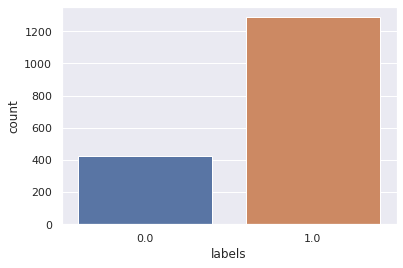

In [ ]:
sns.set_theme(style="darkgrid")
sns.countplot(x='labels', data=pd.DataFrame({'labels': complete_data['label']}))

###Oversampling

In [ ]:
# import library
from imblearn.over_sampling import RandomOverSampler

x = complete_data.drop(['label'], axis=1)
y = complete_data['label']
ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
x_ros, y_ros = ros.fit_resample(x, y)

print('Original dataset shape', y.value_counts())
print('Resample dataset shape', np.unique(y_ros))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Original dataset shape 1.0    1287
0.0     423
Name: label, dtype: int64
Resample dataset shape [0. 1.]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
(unique, counts) = np.unique(y_ros, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[0.000e+00 1.287e+03]
 [1.000e+00 1.287e+03]]


In [ ]:
balanced_df = pd.DataFrame(x_ros)
balanced_df['label'] = y_ros
balanced_df.to_csv('balanced_data.csv', index=False)

In [ ]:
# split into train, validation, test sets with 0.8, 0.1, 0.1 ratio

train_df, validate_df, test_df = np.split(balanced_df.sample(frac=1, random_state=42), [int(.8*len(balanced_df)), int(.9*len(balanced_df))])
train_df.to_csv('train_dataset_b.csv',index=False)
validate_df.to_csv('valid_dataset_b.csv',index=False)
test_df.to_csv('test_dataset_b.csv',index=False)

###Dataset

In [8]:
from torch.utils.data import Dataset

class SoundDataset(Dataset):
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file)   

    def __getitem__(self, idx):
        sound_embedding = self.data_df.drop(['label'],axis=1).iloc[idx]
        label = self.data_df['label'].iloc[idx]
        
        return torch.tensor(sound_embedding, dtype=torch.float), torch.tensor(label, dtype=torch.float)

    def __len__(self):
        return len(self.data_df)

###Get dataset objects (run either one of the blocks below)

In [11]:
# getting the original imbalanced data

train_set = SoundDataset("train_dataset.csv")
valid_set = SoundDataset("valid_dataset.csv")
test_set = SoundDataset("test_dataset.csv")

In [10]:
# getting the processed balanced data

train_set = SoundDataset("train_dataset_b.csv")
valid_set = SoundDataset("valid_dataset_b.csv")
test_set = SoundDataset("test_dataset_b.csv")

###Dataloader

In [12]:
from torch.utils.data import DataLoader
bs = 32
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=bs, shuffle=False)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [13]:
train_iter = iter(train_loader)
valid_iter = iter(valid_loader)
test_iter = iter(test_loader)

In [14]:
input1_train, label_train = next(train_iter)
input1_valid, label_valid = next(valid_iter)
input1_test, label_test = next(test_iter)

###Define model

In [15]:
class VGGISH(nn.Module):
    def __init__(self, input_size=128, hidden_size=64):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(True),           
            nn.Dropout(0.1),            
            nn.Linear(hidden_size, 1),
        )           

    def forward(self, x):
        out = self.classifier(x)
        out = torch.sigmoid(out)
        return out.squeeze(-1)

###Train helper functions

In [16]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


In [17]:
def Train(net, num_epochs, criterion, optimizer):
  valid_loss = 0
  valid_acc = 0

  step_train = 0
  step_valid = 0
  loss_vals_train = []
  loss_vals_valid = []
  thres = 0.5
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      net.train()
      running_loss = 0.0
      running_corrects = 0
      for inputs_1, labels in tqdm(train_loader):

          inputs_1 = inputs_1.to(device)
          labels = labels.to(device)

          '''Training of the model'''
          # Forward pass
          outputs = net(inputs_1)
          loss = criterion(outputs, labels.float())

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          preds=(outputs.data>thres).int()
          running_corrects += torch.sum((preds == labels).int())

      train_loss = running_loss / len(train_loader)
      train_acc = running_corrects / float(len(train_loader.dataset))
      loss_vals_train.append(train_loss)

      with torch.no_grad():
          net.eval()
          running_loss = 0.0
          running_corrects = 0
          for inputs_1, labels in tqdm(valid_loader):
              inputs_1 = inputs_1.to(device)
              labels = labels.to(device)

              outputs = net(inputs_1)
              loss = criterion(outputs, labels.float())

              running_loss += loss.item()

              preds=(outputs.data>thres).int()
              running_corrects += torch.sum((preds == labels).int())

              #auc = roc_auc_score(labels, outputs)
              #print('auc: ' + str(auc))

          valid_loss = running_loss / len(valid_loader)
          valid_acc = running_corrects / float(len(valid_loader.dataset))

          loss_vals_valid.append(valid_loss)

      print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))
      
  return loss_vals_train, loss_vals_valid

In [18]:
def plotLoss(loss_train,loss_valid,epochs):
  range_epochs=np.arange(1, epochs+1, 1)
  fig, ax = plt.subplots()
  ax.plot(range_epochs, loss_train, label='Training loss')
  ax.plot(range_epochs, loss_valid, label='Validation loss')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  leg = ax.legend();

In [19]:
def Test(net, test_loader):
  # testing
  with torch.no_grad():
    net.eval()
    running_loss = 0.0
    running_corrects = 0
    thres = 0.5
    preds_list = []
    predictions = []
    true_labels = []
    for inputs_1, labels in tqdm(test_loader):

        inputs_1 = inputs_1.to(device)
        labels = labels.to(device)

        outputs = net(inputs_1)
        loss = criterion(outputs.unsqueeze(1), labels.float().unsqueeze(1))

        running_loss += loss.item()

        preds=(outputs.data>thres).int()
        running_corrects += torch.sum((preds == labels).int().unsqueeze(1))

        predictions.append(outputs.cpu().detach().numpy())
        preds_list.append(preds.cpu().detach().numpy())
        true_labels.append(labels.cpu().detach().numpy())

  y_true = np.concatenate(true_labels).ravel()
  y_pred = np.concatenate(preds_list).ravel()
  y_prob = np.concatenate(predictions).ravel()
  #print(y_prob)

  print('Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f},  F1 score: {:.4f}, ROC AUC score: {:.4f}'
    .format(precision_score(y_true, y_pred, average='weighted'), 
            recall_score(y_true, y_pred, average='weighted'), 
            accuracy_score(y_true, y_pred), 
            f1_score(y_true, y_pred, average='weighted'),
            roc_auc_score(y_true, y_prob, average='weighted')))

###Training (imbalanced data)

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 0.6716, Train Acc: 0.6396, Valid Loss: 0.6474,  Valid Acc: 0.6901


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 0.6021, Train Acc: 0.7544, Valid Loss: 0.6129,  Valid Acc: 0.6901


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 0.5692, Train Acc: 0.7544, Valid Loss: 0.6092,  Valid Acc: 0.6901


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 0.5630, Train Acc: 0.7544, Valid Loss: 0.6118,  Valid Acc: 0.6901


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 0.5578, Train Acc: 0.7544, Valid Loss: 0.6125,  Valid Acc: 0.6901


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6419, Recall: 0.8012, Accuracy: 0.8012,  F1 score: 0.7127, ROC AUC score: 0.5009


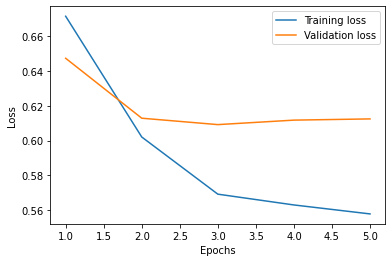

In [20]:
net = VGGISH().to(device)

num_epochs = 5
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002)

# train
loss_vals_train, loss_vals_valid = Train(net, num_epochs, criterion, optimizer)

# plot loss
plotLoss(loss_vals_train,loss_vals_valid,num_epochs)

# test
Test(net, test_loader)

### Training (balanced data)

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.6932, Train Acc: 0.5187, Valid Loss: 0.6847,  Valid Acc: 0.5914


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.6922, Train Acc: 0.5338, Valid Loss: 0.6886,  Valid Acc: 0.5875


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.6868, Train Acc: 0.5391, Valid Loss: 0.6792,  Valid Acc: 0.5253


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.6843, Train Acc: 0.5449, Valid Loss: 0.6804,  Valid Acc: 0.5409


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.6816, Train Acc: 0.5459, Valid Loss: 0.6761,  Valid Acc: 0.5603


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.6799, Train Acc: 0.5682, Valid Loss: 0.6787,  Valid Acc: 0.5331


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.6802, Train Acc: 0.5444, Valid Loss: 0.6708,  Valid Acc: 0.5370


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.6733, Train Acc: 0.5692, Valid Loss: 0.6601,  Valid Acc: 0.5642


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.6706, Train Acc: 0.5624, Valid Loss: 0.6560,  Valid Acc: 0.6226


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.6684, Train Acc: 0.5726, Valid Loss: 0.6623,  Valid Acc: 0.5837


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.6635, Train Acc: 0.5862, Valid Loss: 0.6563,  Valid Acc: 0.6031


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.6628, Train Acc: 0.5731, Valid Loss: 0.6552,  Valid Acc: 0.5798


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.6594, Train Acc: 0.5794, Valid Loss: 0.6570,  Valid Acc: 0.5875


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.6618, Train Acc: 0.5852, Valid Loss: 0.6640,  Valid Acc: 0.5759


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.6547, Train Acc: 0.6017, Valid Loss: 0.6514,  Valid Acc: 0.5681


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.6536, Train Acc: 0.6032, Valid Loss: 0.6288,  Valid Acc: 0.6148


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.6448, Train Acc: 0.6105, Valid Loss: 0.6384,  Valid Acc: 0.5953


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.6441, Train Acc: 0.6090, Valid Loss: 0.6360,  Valid Acc: 0.5992


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.6411, Train Acc: 0.6037, Valid Loss: 0.6678,  Valid Acc: 0.5564


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.6309, Train Acc: 0.6158, Valid Loss: 0.6322,  Valid Acc: 0.6226


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.6319, Train Acc: 0.6139, Valid Loss: 0.6453,  Valid Acc: 0.6187


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.6225, Train Acc: 0.6401, Valid Loss: 0.6254,  Valid Acc: 0.6109


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.6163, Train Acc: 0.6455, Valid Loss: 0.6160,  Valid Acc: 0.6226


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.6132, Train Acc: 0.6425, Valid Loss: 0.6686,  Valid Acc: 0.5914


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.6138, Train Acc: 0.6595, Valid Loss: 0.6195,  Valid Acc: 0.6187


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.6091, Train Acc: 0.6644, Valid Loss: 0.6102,  Valid Acc: 0.6226


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.5978, Train Acc: 0.6663, Valid Loss: 0.5994,  Valid Acc: 0.6576


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.6042, Train Acc: 0.6561, Valid Loss: 0.6126,  Valid Acc: 0.6187


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.5856, Train Acc: 0.6809, Valid Loss: 0.6198,  Valid Acc: 0.6070


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.5815, Train Acc: 0.6775, Valid Loss: 0.6043,  Valid Acc: 0.6381


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.5759, Train Acc: 0.6955, Valid Loss: 0.6328,  Valid Acc: 0.6031


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.5670, Train Acc: 0.6926, Valid Loss: 0.6016,  Valid Acc: 0.6381


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.5643, Train Acc: 0.6863, Valid Loss: 0.5957,  Valid Acc: 0.6498


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.5678, Train Acc: 0.6965, Valid Loss: 0.6617,  Valid Acc: 0.5992


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.5548, Train Acc: 0.7105, Valid Loss: 0.5846,  Valid Acc: 0.6576


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.5487, Train Acc: 0.7212, Valid Loss: 0.6026,  Valid Acc: 0.6615


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.5558, Train Acc: 0.7096, Valid Loss: 0.5945,  Valid Acc: 0.6498


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.5464, Train Acc: 0.7033, Valid Loss: 0.6175,  Valid Acc: 0.6498


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.5323, Train Acc: 0.7266, Valid Loss: 0.5675,  Valid Acc: 0.7121


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.5233, Train Acc: 0.7402, Valid Loss: 0.5610,  Valid Acc: 0.6654


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.5235, Train Acc: 0.7309, Valid Loss: 0.5632,  Valid Acc: 0.6770


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.5175, Train Acc: 0.7314, Valid Loss: 0.5446,  Valid Acc: 0.7121


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.5226, Train Acc: 0.7280, Valid Loss: 0.5910,  Valid Acc: 0.6693


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.5171, Train Acc: 0.7421, Valid Loss: 0.6194,  Valid Acc: 0.6498


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.5154, Train Acc: 0.7426, Valid Loss: 0.5364,  Valid Acc: 0.7237


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.5011, Train Acc: 0.7547, Valid Loss: 0.5481,  Valid Acc: 0.6770


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.4960, Train Acc: 0.7601, Valid Loss: 0.5449,  Valid Acc: 0.6887


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.4943, Train Acc: 0.7596, Valid Loss: 0.5505,  Valid Acc: 0.6926


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.4849, Train Acc: 0.7669, Valid Loss: 0.5319,  Valid Acc: 0.7198


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.4960, Train Acc: 0.7567, Valid Loss: 0.5552,  Valid Acc: 0.6926


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.4738, Train Acc: 0.7785, Valid Loss: 0.5504,  Valid Acc: 0.7043


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.4592, Train Acc: 0.7882, Valid Loss: 0.5610,  Valid Acc: 0.6770


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.4720, Train Acc: 0.7703, Valid Loss: 0.5400,  Valid Acc: 0.7043


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.4728, Train Acc: 0.7766, Valid Loss: 0.5232,  Valid Acc: 0.7276


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.4611, Train Acc: 0.7800, Valid Loss: 0.5106,  Valid Acc: 0.7315


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.4558, Train Acc: 0.7839, Valid Loss: 0.5553,  Valid Acc: 0.7276


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.4365, Train Acc: 0.7989, Valid Loss: 0.5234,  Valid Acc: 0.7160


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.4474, Train Acc: 0.7819, Valid Loss: 0.5560,  Valid Acc: 0.7198


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.4398, Train Acc: 0.8018, Valid Loss: 0.5413,  Valid Acc: 0.7237


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.4456, Train Acc: 0.7882, Valid Loss: 0.5012,  Valid Acc: 0.7471


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.4340, Train Acc: 0.7950, Valid Loss: 0.5241,  Valid Acc: 0.7160


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.4207, Train Acc: 0.8106, Valid Loss: 0.5081,  Valid Acc: 0.7354


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.4215, Train Acc: 0.8174, Valid Loss: 0.5258,  Valid Acc: 0.7004


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.4229, Train Acc: 0.8052, Valid Loss: 0.5224,  Valid Acc: 0.7549


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.4117, Train Acc: 0.8101, Valid Loss: 0.5075,  Valid Acc: 0.7276


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.4074, Train Acc: 0.8164, Valid Loss: 0.5512,  Valid Acc: 0.7276


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.3951, Train Acc: 0.8198, Valid Loss: 0.5619,  Valid Acc: 0.7315


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.3985, Train Acc: 0.8256, Valid Loss: 0.5130,  Valid Acc: 0.7471


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.4117, Train Acc: 0.8135, Valid Loss: 0.5231,  Valid Acc: 0.7276


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.4013, Train Acc: 0.8154, Valid Loss: 0.5075,  Valid Acc: 0.7315


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.3964, Train Acc: 0.8208, Valid Loss: 0.5032,  Valid Acc: 0.7354


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.3989, Train Acc: 0.8227, Valid Loss: 0.4946,  Valid Acc: 0.7121


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.3788, Train Acc: 0.8388, Valid Loss: 0.5249,  Valid Acc: 0.7432


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.3943, Train Acc: 0.8227, Valid Loss: 0.5100,  Valid Acc: 0.7160


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.3954, Train Acc: 0.8218, Valid Loss: 0.5043,  Valid Acc: 0.7665


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.3743, Train Acc: 0.8329, Valid Loss: 0.4815,  Valid Acc: 0.7432


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.3708, Train Acc: 0.8402, Valid Loss: 0.4999,  Valid Acc: 0.7704


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.3702, Train Acc: 0.8397, Valid Loss: 0.5181,  Valid Acc: 0.7432


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.3597, Train Acc: 0.8378, Valid Loss: 0.4917,  Valid Acc: 0.7588


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.3532, Train Acc: 0.8436, Valid Loss: 0.4929,  Valid Acc: 0.7354


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.3578, Train Acc: 0.8388, Valid Loss: 0.4823,  Valid Acc: 0.7549


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.3600, Train Acc: 0.8494, Valid Loss: 0.5053,  Valid Acc: 0.7626


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.3516, Train Acc: 0.8446, Valid Loss: 0.4744,  Valid Acc: 0.7510


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.3563, Train Acc: 0.8383, Valid Loss: 0.4827,  Valid Acc: 0.7626


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.3486, Train Acc: 0.8499, Valid Loss: 0.4681,  Valid Acc: 0.7665


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.3602, Train Acc: 0.8470, Valid Loss: 0.5397,  Valid Acc: 0.7198


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.3372, Train Acc: 0.8480, Valid Loss: 0.5033,  Valid Acc: 0.7432


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.3461, Train Acc: 0.8494, Valid Loss: 0.4738,  Valid Acc: 0.7899


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.3334, Train Acc: 0.8572, Valid Loss: 0.5113,  Valid Acc: 0.7471


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.3257, Train Acc: 0.8596, Valid Loss: 0.4897,  Valid Acc: 0.7315


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.3466, Train Acc: 0.8499, Valid Loss: 0.5376,  Valid Acc: 0.7432


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.3267, Train Acc: 0.8538, Valid Loss: 0.4739,  Valid Acc: 0.7549


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.3324, Train Acc: 0.8567, Valid Loss: 0.5222,  Valid Acc: 0.7276


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.3322, Train Acc: 0.8577, Valid Loss: 0.5308,  Valid Acc: 0.7743


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.3363, Train Acc: 0.8587, Valid Loss: 0.5272,  Valid Acc: 0.7510


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.3117, Train Acc: 0.8703, Valid Loss: 0.4635,  Valid Acc: 0.7743


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.3142, Train Acc: 0.8679, Valid Loss: 0.4616,  Valid Acc: 0.7626


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.3195, Train Acc: 0.8650, Valid Loss: 0.5019,  Valid Acc: 0.7626


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.3308, Train Acc: 0.8606, Valid Loss: 0.4829,  Valid Acc: 0.7665


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.2941, Train Acc: 0.8742, Valid Loss: 0.4699,  Valid Acc: 0.7821


  0%|          | 0/9 [00:00<?, ?it/s]

Precision: 0.7636, Recall: 0.7519, Accuracy: 0.7519,  F1 score: 0.7485, ROC AUC score: 0.8095


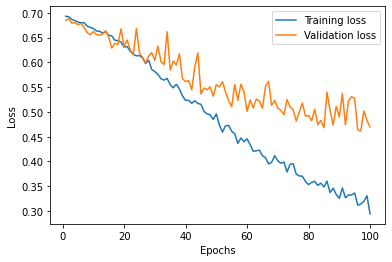

In [ ]:
net = VGGISH().to(device)

num_epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

# train
loss_vals_train, loss_vals_valid = Train(net, num_epochs, criterion, optimizer)

# plot loss
plotLoss(loss_vals_train,loss_vals_valid,num_epochs)

# test
Test(net, test_loader)